In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # 正常顯示中文標籤

In [5]:
# 讀取 CSV 文件
dp001_exam = pd.read_csv('../2024初賽用開放資料/dp001_exam.csv')
dp001_prac = pd.read_csv('../2024初賽用開放資料/dp001_prac.csv')
dp001_review_plus = pd.read_csv('../2024初賽用開放資料/dp001_review_plus.csv')
dp001_review = pd.read_csv('../2024初賽用開放資料/dp001_review.csv')
dp002_exam = pd.read_csv('../2024初賽用開放資料/dp002_exam.csv')
dp003_math = pd.read_csv('../2024初賽用開放資料/dp003_math.csv')
dp003_word = pd.read_csv('../2024初賽用開放資料/dp003_word.csv')
user_data = pd.read_csv('../2024初賽用開放資料/user_data.csv')

In [6]:
# 有這些科目
dp001_prac['subject_name'].unique()

array(['自然108', '國語文108', '數學108', '數學', nan, '防災', '英語108', '表演藝術',
       '國語文', '音樂', '海洋與環境', '健康與體育', '視覺藝術', '自然', '資訊教育'], dtype=object)

In [7]:
merged_data = pd.merge(dp001_prac, user_data, on='user_sn', how='left') # 合併兩個 DataFrame
filtered_data = merged_data[merged_data['subject_name'].isin(['國語文108', '數學108', '數學', '英語108', '國語文'])]

## 個別科目
- 統整個別user總during_time, 答題數:at_count, 每個問題平均花費時間time_per_question, user_data之科目成績

In [8]:

chinese_data = merged_data[merged_data['subject_name'].isin(['國語文108', '國語文'])] # 篩選國語文科目
chinese_data = chinese_data.assign(at_count=chinese_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

total_during_time = chinese_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum'}).reset_index() # 計算總答題數與總作答時間
total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count']
total_during_time = total_during_time.merge(user_data[['user_sn', 'chinese_score']], on='user_sn', how='left')
total_during_time

,user_sn,during_time,at_count,time_per_question,chinese_score
0,4381,495,22.0,22.500000,70
1,4561,37,5.0,7.400000,77
2,6828,538,48.0,11.208333,83
3,11312,167,21.0,7.952381,97
4,14314,456,64.0,7.125000,77
5,23061,278,38.0,7.315789,37
6,23415,1005,45.0,22.333333,23
7,30835,600,64.0,9.375000,73
8,38371,66,12.0,5.500000,37
9,46696,15,2.0,7.500000,67


### Regression Results

In [9]:
X = total_during_time['time_per_question']
y = total_during_time['chinese_score']
X = sm.add_constant(X)  # 增加截距項
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          chinese_score   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.289
Date:                Mon, 28 Oct 2024   Prob (F-statistic):              0.263
Time:                        13:08:46   Log-Likelihood:                -176.30
No. Observations:                  41   AIC:                             356.6
Df Residuals:                      39   BIC:                             360.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                60.5098      6.89

### 散佈圖，針對time_per_question與user_Data的科目成績

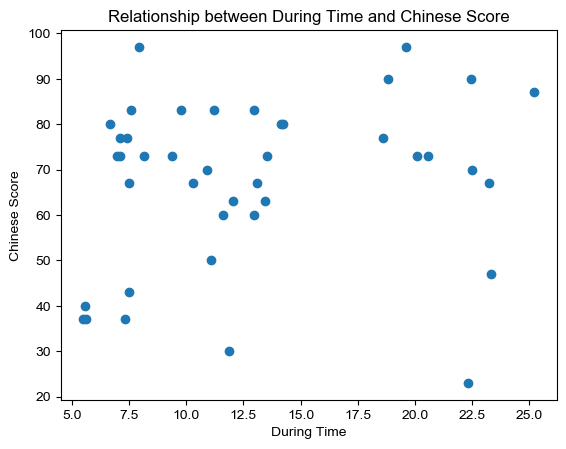

                            OLS Regression Results                            
Dep. Variable:          chinese_score   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.289
Date:                Mon, 28 Oct 2024   Prob (F-statistic):              0.263
Time:                        13:08:46   Log-Likelihood:                -176.30
No. Observations:                  41   AIC:                             356.6
Df Residuals:                      39   BIC:                             360.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                60.5098      6.89

In [10]:
plt.scatter(total_during_time['time_per_question'], total_during_time['chinese_score'])
plt.xlabel('During Time')
plt.ylabel('Chinese Score')
plt.title('Relationship between During Time and Chinese Score')
plt.show()

X = total_during_time['time_per_question']
y = total_during_time['chinese_score']
X = sm.add_constant(X)  # 增加截距項
model = sm.OLS(y, X).fit()
print(model.summary())


### 針對英文

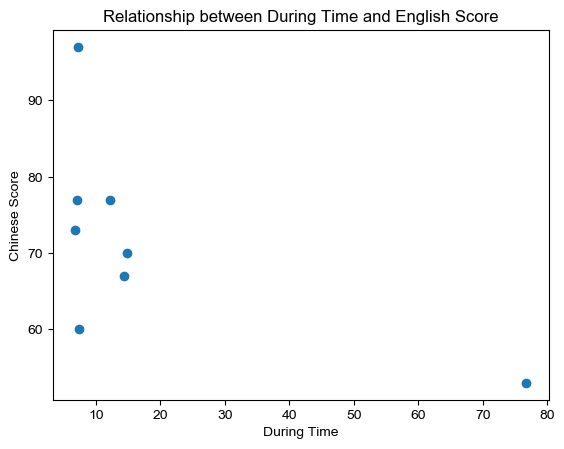

In [11]:
eng_data = merged_data[merged_data['subject_name'].isin(['英語108'])] # 篩選英文文科目
eng_data = eng_data.assign(at_count=eng_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

total_during_time = eng_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum'}).reset_index() # 計算總答題數與總作答時間
total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count']
total_during_time = total_during_time.merge(user_data[['user_sn', 'chinese_score']], on='user_sn', how='left')


plt.scatter(total_during_time['time_per_question'], total_during_time['chinese_score'])
plt.xlabel('During Time')
plt.ylabel('Chinese Score')
plt.title('Relationship between During Time and English Score')
plt.show()

### 針對數學

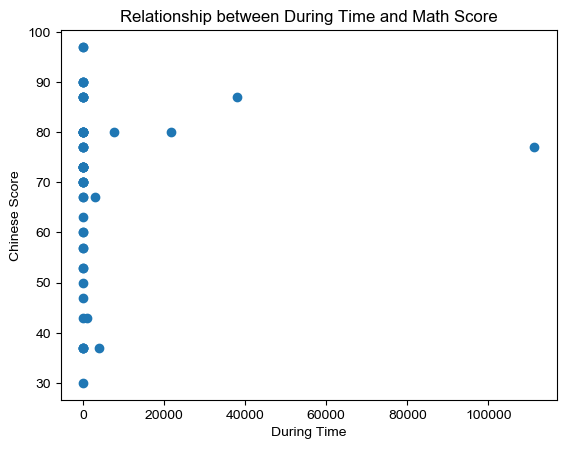

In [12]:
math_data = merged_data[merged_data['subject_name'].isin(['數學108', '數學'])] # 篩選數學文科目
math_data = math_data.assign(at_count=math_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

total_during_time = math_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum'}).reset_index() # 計算總答題數與總作答時間
total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count']
total_during_time = total_during_time.merge(user_data[['user_sn', 'chinese_score']], on='user_sn', how='left')


plt.scatter(total_during_time['time_per_question'], total_during_time['chinese_score'])
plt.xlabel('During Time')
plt.ylabel('Chinese Score')
plt.title('Relationship between During Time and Math Score')
plt.show()

## "總作答時間"與"score_rate"之間的關係 function

In [13]:
def relationship_between_during_time_and_score_rate(data, subject_name, subject_score): # 繪製作答時間與分數之間的關係
    # subject_data = data[data['subject_name'].isin([subject_name])]
    subject_data = data[data['subject_name'].isin(subject_name)] # 篩選科目
    subject_data = subject_data.assign(at_count=subject_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

    total_during_time = subject_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum', 'score_rate': 'mean'}).reset_index() # 計算總答題數與總作答時間
    total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count'] # 計算平均每題作答時間
    total_during_time = total_during_time.merge(user_data[['user_sn', subject_score]], on='user_sn', how='left') # 合併分數資料
    
    total_during_time = total_during_time[total_during_time['during_time'] < 3000] # 篩選作答時間小於1200的資料


    X = total_during_time['during_time']
    y = total_during_time['score_rate']
    X = sm.add_constant(X)  # 增加截距項
    model = sm.OLS(y, X).fit()
    print(model.summary()) # 顯示迴歸結果
    
    plt.scatter(total_during_time['during_time'], total_during_time['score_rate']) # 繪製散點圖
    plt.xlabel('Total During Time')
    plt.ylabel('Score Rate')
    plt.title(f'Relationship between During Time and Score Rate in {subject_name}')
    plt.show()

# 用不到了
# math_data = merged_data[merged_data['subject_name'].isin(['國語文108', '國語文'])] # 篩選國文科目
# math_data = math_data.assign(at_count=math_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

# total_during_time = math_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum', 'score_rate': 'mean'}).reset_index() # 計算總答題數與總作答時間
# total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count']
# total_during_time = total_during_time.merge(user_data[['user_sn', 'chinese_score']], on='user_sn', how='left')

# # longer_during_time = total_during_time[(total_during_time['during_time'] < 200) & (total_during_time['at_count'] < 20)]

# plt.scatter(total_during_time['during_time'], total_during_time['score_rate'])
# plt.xlabel('Total During Time')
# plt.ylabel('Total Score Rate')
# plt.title('Relationship between During Time and Score Rate in dp001_prac')
# plt.show()
# # total_during_time



                            OLS Regression Results                            
Dep. Variable:             score_rate   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     13.37
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           0.000752
Time:                        13:08:47   Log-Likelihood:                -174.78
No. Observations:                  41   AIC:                             353.6
Df Residuals:                      39   BIC:                             357.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          55.9589      4.916     11.383      

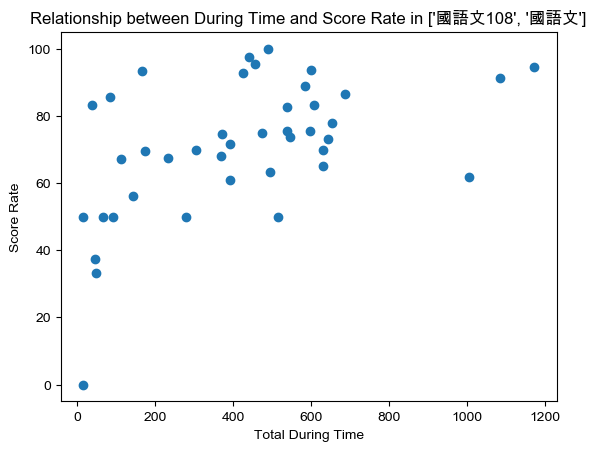

                            OLS Regression Results                            
Dep. Variable:             score_rate   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7727
Date:                Mon, 28 Oct 2024   Prob (F-statistic):              0.384
Time:                        13:08:47   Log-Likelihood:                -211.71
No. Observations:                  51   AIC:                             427.4
Df Residuals:                      49   BIC:                             431.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          71.8258      3.668     19.580      

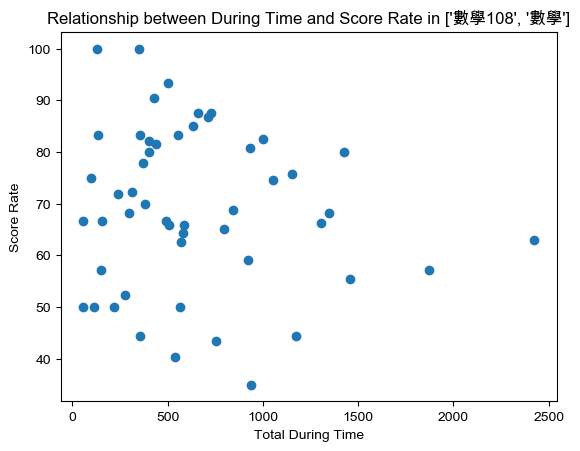

                            OLS Regression Results                            
Dep. Variable:             score_rate   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.7887
Date:                Mon, 28 Oct 2024   Prob (F-statistic):              0.409
Time:                        13:08:47   Log-Likelihood:                -33.542
No. Observations:                   8   AIC:                             71.08
Df Residuals:                       6   BIC:                             71.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          79.8538      8.938      8.934      

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)


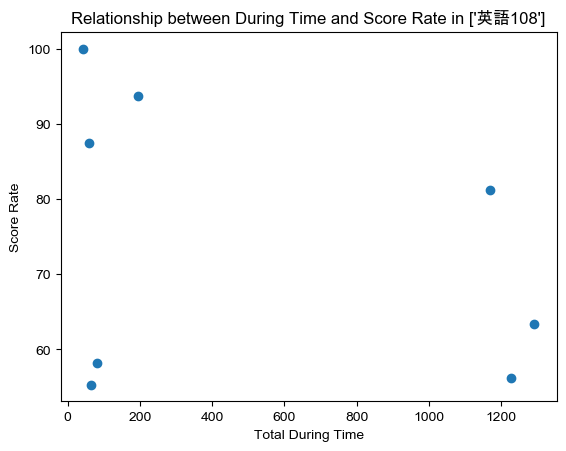

In [14]:
relationship_between_during_time_and_score_rate(merged_data, ['國語文108', '國語文'], 'chinese_score')
relationship_between_during_time_and_score_rate(merged_data, ['數學108', '數學'], 'math_score')
relationship_between_during_time_and_score_rate(merged_data, ['英語108'], 'english_score')